In [11]:
import sys
sys.path.append("..")
import pandas as pd
import util_functions as uf
import altair as alt
import json
import requests
import numpy as np
from datetime import date

In [2]:
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [3]:
def daily_totals(con):
    # Query Dockless Start by ANC and Overlaps
    return pd.read_sql("""/* Spin, Jump and Mobike*/
                        (SELECT
                        created::date as date, 
                        provider, 
                        COUNT(DISTINCT bike_id) as bike_count
                        FROM bike_locations
                        WHERE provider not in ('ofo','limebike')                    
                        GROUP BY provider, created::date)
                        /* Ofo*/
                        UNION
                        (SELECT 
                        created as date, 
                        'ofo' as provider, 
                        max("count") as bike_count
                        from 
                        (select 
                        count(bike_id), 
                        bike_id, 
                        created::date 
                        from bike_locations
                         WHERE 
                         provider='ofo'
                        group by bike_id, created::date) as counts_per_batch
                        group by created
                        )
                        /*Lime Bikes*/
                        UNION
                        (SELECT
                        locations.date,
                        'lime' as provider,
                        count(distinct locations.bike_id) as bike_count
                        from 
                        (select distinct
                        created::date as date, bike_id 
                        from bike_locations
                        where provider='limebike') as locations
                        LEFT JOIN
                        (SELECT DISTINCT bike_id
                        from bike_locations
                        where raw->'attributes'->>'vehicle_type'='scooter') as scooters
                        on locations.bike_id = scooters.bike_id
                        where scooters.bike_id is null
                        group by 1,2
                        order by 1,2)
                        order by provider, date;
                """, con=con)

In [98]:
uf.set_env_path()
conn, cur = uf.local_connect()
# Return Dataframe bike per day
df = daily_totals(con=conn)

df.to_csv("daily_bike_count.csv")

## Format the Dataframe

In [99]:
# Convert date fields to datetime
df['date'] = pd.to_datetime(df['date'])

# Smooth out days with outliers due to API issues
df['bike_count'] = np.where((df['provider'] == 'ofo') & 
                             (df['bike_count'] < 20) & 
                              (df['date'] <= '2018-04-10'), 400, df['bike_count'])
df['bike_count'] = np.where((df['bike_count'] > 500) & 
                            (df['date'] <= '2018-04-10'), 450, df['bike_count'])

## Spin Bikes Disappear on 8/17

In [132]:
spin_df = df[df['provider'] == 'spin']
# Pad out the rest of the days in the Dataframe
spin_padding_df = pd.DataFrame(pd.date_range(start=spin_df['date'].max(), end=df['date'].max()), columns=['date'])
spin_padding_df['bike_count'] = 0
spin_padding_df['provider'] = 'spin'

spin_df = pd.concat([spin_df, spin_padding_df], axis=0)
spin_df.tail()

,bike_count,date,provider
119,0,2018-09-10,spin
120,0,2018-09-11,spin
121,0,2018-09-12,spin
122,0,2018-09-13,spin
123,0,2018-09-14,spin


In [133]:
# Merge on spin exit date
spin_dates = [date(2018,8,17)]
spin_events = ['Spin exits DC market ']

# Define Dataframe of Mobike Events
spin_events_df = pd.DataFrame({'date': spin_dates, 'spin_event': spin_events})
spin_events_df['provider'] = 'spin'
spin_events_df['date'] = pd.to_datetime(spin_events_df['date'])

# Merge on Dataframe of Mobike Events
spin_df = spin_df.merge(spin_events_df, on=['date', 'provider'], how='left')


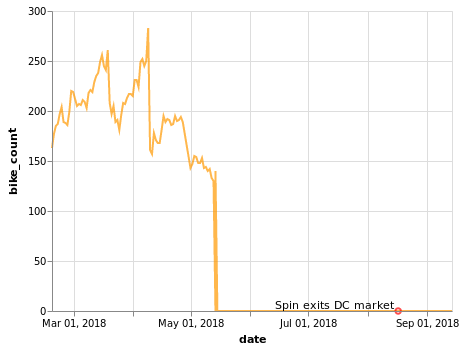

In [172]:
line_chart = alt.Chart(spin_df).mark_line(opacity=0.7).encode(
             alt.X('date'),
             alt.Y('bike_count'),
             alt.Color('provider',
                       legend=None,
                      scale=alt.Scale(range=['#ff9900']))
             )

# spin points
spin_points = alt.Chart(spin_df[~spin_df['spin_event'].isnull()]
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('bike_count')
)

# Spin Annotated points
spin_text = spin_points.mark_text(
                  align='right',
                  baseline='bottom',
        ).encode(
            text='spin_event',
        )

line_chart + spin_points + spin_text

### Plot Notes

* Spin has about 50 bikes still showing on their API.  Most are in a warehouse in Ivy City, while there are a handle that seem to be out in the wild
* Reached out to Transit app to see if I can fill in the gap here
* Spin averaging about 200 bikes for the time period we have, but start to creep below 150 right before data goes missing on my end

## Ofo and Mobike Only (Chinese Companies that largely left US Market)

In [102]:
chinese_df = df[df['provider'].isin(['ofo', 'mobike'])]

# Pivot Dataframe so each provider has same dates, Fill in zeros for mobike
chinese_df = chinese_df.pivot(index='date', columns='provider', values='bike_count')
chinese_df['mobike'].fillna(0, inplace=True)
chinese_df['ofo'].fillna(400, inplace=True)
chinese_df.reset_index(inplace=True)

# Melt Dataframe for plotting in Altair
chinese_df =  pd.melt(chinese_df, id_vars=['date'],
                         value_vars=['mobike', 'ofo'],
                         value_name = 'bike_count',
                      
                         var_name = 'provider',
                         )

### Add Timeline Events to Dataframe to Annotate Plot

* 4/27/2018 - DDOT extends pilot to Aug
* 7/20/2018 - Mobike app goes dark
* 7/24/2018 - Ofo announces DC exit
* 7/25/2018 - Mobike announces DC exit
* 7/30/2018 - Ofo DC exit


In [103]:
mobike_dates = [date(2018,4,27), date(2018,7,20), date(2018,7,25)]
mobike_events = ['DDOT extends pilot  ', 
                  'Mobike app goes dark   ', 
                  'Mobike annouces exit ']

ofo_dates = [date(2018,7,24), date(2018,7,30)]
ofo_events = ['  Ofo annouces exit', '  Ofo exits']

# Define Dataframe of Mobike Events
mobike_events_df = pd.DataFrame({'date': mobike_dates, 'mobike_event': mobike_events})
mobike_events_df['provider'] = 'mobike'
mobike_events_df['date'] = pd.to_datetime(mobike_events_df['date'])

# Merge on Dataframe of Mobike Events
chinese_df = chinese_df.merge(mobike_events_df, on=['date', 'provider'], how='left')
chinese_df['mobike_event'] =  chinese_df['mobike_event'].fillna('')

# Define Dataframe of Ofo Events
ofo_events_df = pd.DataFrame({'date': ofo_dates, 'ofo_event': ofo_events})
ofo_events_df['provider'] = 'ofo'
ofo_events_df['date'] = pd.to_datetime(ofo_events_df['date'])

# Merge on Dataframe of Ofo Events
chinese_df = chinese_df.merge(ofo_events_df, on=['date', 'provider'], how='left')
chinese_df['ofo_event'] =  chinese_df['ofo_event'].fillna('')


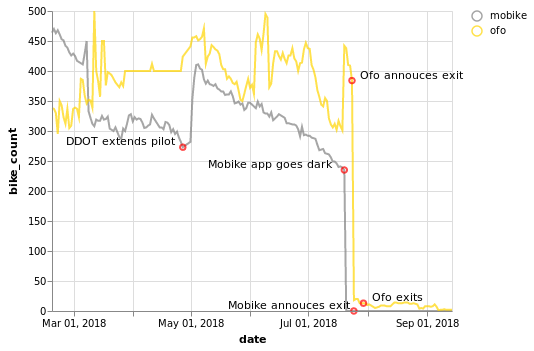

In [171]:
line_chart = alt.Chart(chinese_df).mark_line(opacity=0.7).encode(
             alt.X('date'),
             alt.Y('bike_count'),
             alt.Color('provider',
                       legend=alt.Legend(title=None, orient='right'),
                       scale=alt.Scale(range=['#808080','#ffd500']))
             )


# Mobike points
mobike_points = alt.Chart(chinese_df[chinese_df['mobike_event'] != '']
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('bike_count')
)

# Mobike Annotated points
mobike_text = mobike_points.mark_text(
                  align='right',
                  baseline='bottom',
        ).encode(
            text='mobike_event',
        )

# Ofo points
ofo_points = alt.Chart(chinese_df[chinese_df['ofo_event'] != '']
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('bike_count')
)

# Ofo Annotated points
ofo_text = ofo_points.mark_text(
                  align='left',
                  baseline='bottom',
        ).encode(
            text='ofo_event',
        )



line_chart + mobike_points + mobike_text + ofo_points + ofo_text

### Plot Notes


* Ofo and Mobike take different tactics for leaving the DC market.  
* Ofo maintains about 400 bikes on the street until 7/24 the day of they announce they are leaving the DC market.  You can see above that they even replenish their on street bikes several days before the annoucement, going from 300 to 450 bikes on the street. Once the annoucement is made, the number of Ofo bikes drops suddently from 400 to 18.
* While Mobike's exit annoucement may have seen just as suddet, by comparison, Mobike more gradually paired down it's fleet. Above, we can see a surge on Mobikes put on the street right after DDOT annouces the extension of the DoBi pilot through August on April 27, but from this point on Mobike doesn't replenish it's fleet, letting the total Mobikes on the street dip below 250 bikes as of July 20th when the Mobike app goes dark - 4 days before they annouce their exit from the DC market.


## Plotting All Operators (Jump Analysis)

In [153]:
# Merge on spin exit date
jump_dates = [date(2018,8,30)]
jump_events = ['  DDOT extends pilot through Dec ']

# Define Dataframe of Mobike Events
jump_events_df = pd.DataFrame({'date': jump_dates, 'jump_event': jump_events})
jump_events_df['provider'] = 'JUMP'
jump_events_df['date'] = pd.to_datetime(spin_events_df['date'])

# Merge on Dataframe of Mobike Events
jump_df = df.merge(jump_events_df, on=['date', 'provider'], how='left')

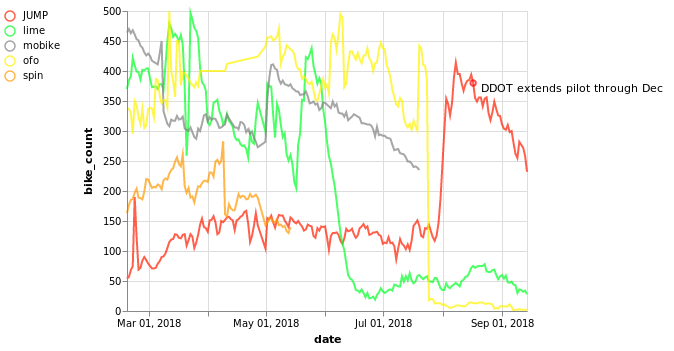

In [169]:
line_chart = alt.Chart(jump_df).mark_line(opacity=0.7).encode(
                 alt.X('date'),
                 alt.Y('bike_count'),
                 alt.Color('provider',
                            legend=alt.Legend(title=None, orient='left'), 
                 scale=alt.Scale(range=['#ff1d00', '#00ff26', '#808080', '#fff200', '#ff9900']))
            )

# jump points
jump_points = alt.Chart(jump_df[~jump_df['jump_event'].isnull()]
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('bike_count')
)

# Jump Annotated points
jump_text = jump_points.mark_text(
                  align='left',
                  baseline='top',
        ).encode(
            text='jump_event',
        )

line_chart  + jump_points + jump_text

### Jump Notes

* Jump capitalizes on Ofo and Mobike departing the DC market by increasing it's fleet size from 126 on July 29th to 414 on August 8th.
* It seems as if maintaing such a larger fleet is starting to take it's toll on Jump, as the daily number of bikes on the street has been in steady decline since August 8th (similar to Lime decline once started all scooters)


## Conclusion Notes

* All stakeholders involved had some impact on dockless bike exit
 * _Chinese Dockless Operators_ - Opportunity costs, strategitic exited US markets, Mobike stayed in markets with less established docked bikeshare systems, citing Charlotte
 * _Dockless Operators transition to scooters_ - Both Spin and Lime found that scooters cited popularity of scooters for either replacing their entire fleet or exiting the market completely to retool their business model
 * _DDOT extending the pilot twice_ - What once was an 9 month pilot has now become a 16 month pilot due to two extends by DDOT either a few days before or on the day the pilot was set to end.  Operators cited this moving  goal post and restrictive rules as reasons why they either left the market or converted to scooters.  The most interesting move that DDOT made was attached a new rule to the most recent pilot extension requiring  all dockless bikes have the ability to lock to a fixed structure like a bike rack.  While this rule may have been viewed as unnecessary, since Jump (which adheres to this rule) was the only dockless operator left when the rule was made, I see this rule as foreshadowing what rules and operators DDOT favors coming out of the pilot
 
 